# Popular Data Science Questions
Our goal in this project is to use Data Science Stack Exchange to determine what content should a data science education company create, based on interest by subject.

## Stack Exchange
**What kind of questions are welcome on this site?**
On DSSE's help center's section on questions , we can read that we should:

- Avoid subjective questions.
- Ask practical questions about Data Science — there are adequate sites for theoretical questions.
- Ask specific questions.
- Make questions relevant to others.
- All of these characteristics, if employed, should be helpful attributes to our goal.

In the help center we also learned that in addition to the sites mentioned in the Learn section, there are other two sites that are relevant:

Open Data (Dataset requests)
Computational Science (Software packages and algorithms in applied mathematics)
**What, other than questions, does DSSE's home subdivide into?**
On the home page we can see that we have four sections:

- Questions — a list of all questions asked;
- Tags — a list of tags (keywords or labels that categorize questions);
- Users — a list of users;
- Unanswered — a list of unanswered questions;

The tagging system used by Stack Exchange looks just like what we need to solve this problem as it allow us to quantify how many questions are asked about each subject.

Something else we can learn from exploring the help center, is that Stack Exchange's sites are heavily moderated by the community; this gives us some confidence in using the tagging system to derive conclusions.

**What information is available in each post?**
Looking, just as an example, at this question, some of the information we see is:

- For both questions and answers:
    - The posts's score;
    - The posts's title;
    - The posts's author;
    - The posts's body;
- For questions only:
    - How many users have it on their "
    - The last time the question as active;
    - How many times the question was viewed;
    - Related questions;
    - The question's tags;

**Stack Exchange Data Explorer**
Perusing the table names, a few stand out as relevant for our goal:

Posts
PostTags
Tags
TagSynonyms
Running a few exploratory queries, leads us to focus our efforts on Posts table. For examples, the Tags table looked very promising as it tells us how many times each tag was used, but there's no way to tell just from this if the interest in these tags is recent or a thing from the past.

## Getting the Data

To get the revelavnt data we run this query

```
SELECT Id, CreationDate,
       Score, ViewCount, Tags,
       AnswerCount, FavoriteCount
  FROM posts
 WHERE PostTypeId = 1 AND YEAR(CreationDate) = 2019;

```

and you wil get something like this:

![](QueryResult.png)

## Exploring the Data
We can read in the data while immediately making sure CreationDate will be stored as a datetime object:

In [35]:
# We import everything that we'll use

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [36]:
questions = pd.read_csv("2019_questions.csv", parse_dates=["CreationDate"])


In [37]:
questions.info() #to get soem information 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8839 entries, 0 to 8838
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Id             8839 non-null   int64         
 1   CreationDate   8839 non-null   datetime64[ns]
 2   Score          8839 non-null   int64         
 3   ViewCount      8839 non-null   int64         
 4   Tags           8839 non-null   object        
 5   AnswerCount    8839 non-null   int64         
 6   FavoriteCount  1407 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 483.5+ KB


We see that only FavoriteCount has missing values. A missing value on this column probably means that the question was is not present in any users' favorite list, so we can replace the missing values with zero.

The types seem adequate for every column, however, after we fill in the missing values on FavoriteCount, there is no reason to store the values as floats.

Since the object dtype is a catch-all type, let's see what types the objects in questions ["Tags"] are.

In [38]:
questions["Tags"].apply(lambda value: type(value)).unique()


array([<class 'str'>], dtype=object)

We see that every value in this column is a string. On Stack Exchange, each question can only have a maximum of five tags (source), so one way to deal with this column is to create five columns in questions called Tag1, Tag2, Tag3, Tag4, and Tag5 and populate the columns with the tags in each row.

However, since doesn't help is relating tags from one question to another, we'll just keep them as a list.

## Cleaning the Data
We'll begin by fixing FavoriteCount.

In [39]:
questions.fillna(value={"FavoriteCount": 0}, inplace=True)
questions["FavoriteCount"] = questions["FavoriteCount"].astype(int)
questions.dtypes

Id                        int64
CreationDate     datetime64[ns]
Score                     int64
ViewCount                 int64
Tags                     object
AnswerCount               int64
FavoriteCount             int32
dtype: object

Lets modify `Tags` to make it easier to work with

In [40]:
questions["Tags"] = questions["Tags"].str.replace("^<|>$", "").str.split("><")
questions.sample(3)

,Id,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
4317,49645,2019-04-20 17:10:31,1,207,"[python, keras, autoencoder]",1,0
1808,46776,2019-03-06 11:03:01,0,76,"[machine-learning, python, pca, dimensionality...",1,0
3979,61143,2019-10-02 11:06:14,0,23,[neural-network],2,0


## Most Used and Most Viewed
We'll begin by counting how many times each tag was used

In [41]:
tag_count = dict()

for tags in questions["Tags"]:
    for tag in tags:
        if tag in tag_count:
            tag_count[tag] += 1
        else:
            tag_count[tag] = 1

For improved aesthetics, let's transform tag_count in a dataframe.

In [42]:
tag_count = pd.DataFrame.from_dict(tag_count, orient="index")
tag_count.rename(columns={0: "Count"}, inplace=True)
tag_count.head(10)

,Count
machine-learning,2693
data-mining,217
regression,347
linear-regression,175
regularization,50
python,1814
time-series,466
forecast,34
forecasting,85
scikit-learn,540


Let's now sort this dataframe by Count and visualize the top 20 results.

In [43]:
most_used = tag_count.sort_values(by="Count").tail(20)
most_used

,Count
machine-learning-model,224
statistics,234
clustering,257
predictive-modeling,265
r,268
dataset,340
regression,347
pandas,354
lstm,402
time-series,466


The threshold of 20 is somewhat arbitrary and we can experiment with others, however, popularity of the tags rapidly declines, so looking at these tags should be enough to help us with our goal. Let's visualize these data.

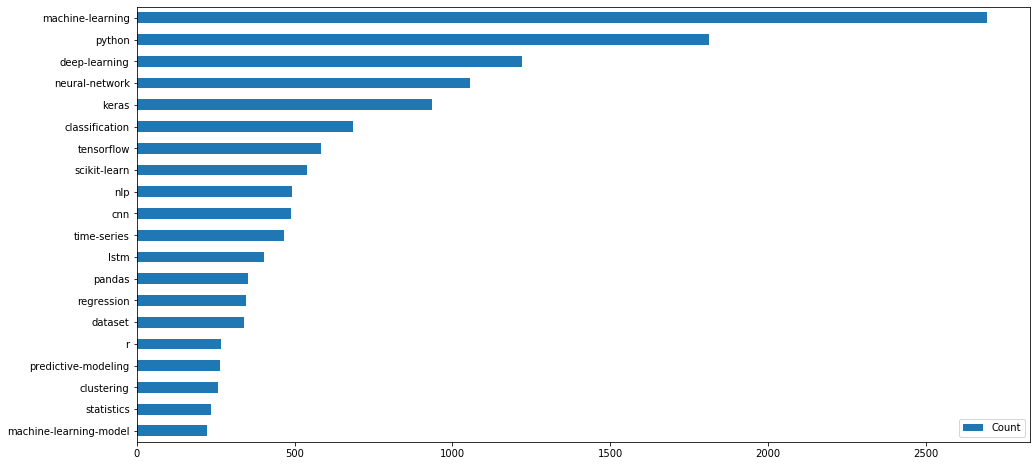

In [44]:
most_used.plot(kind="barh", figsize=(16,8))

Some tags are very, very broad and are unlikely to be useful; e.g.: python, dataset, r. Before we investigate the tags a little deeper, let's repeat the same process for views.

We'll use pandas's `pandas.DataFrame.iterrows()`.

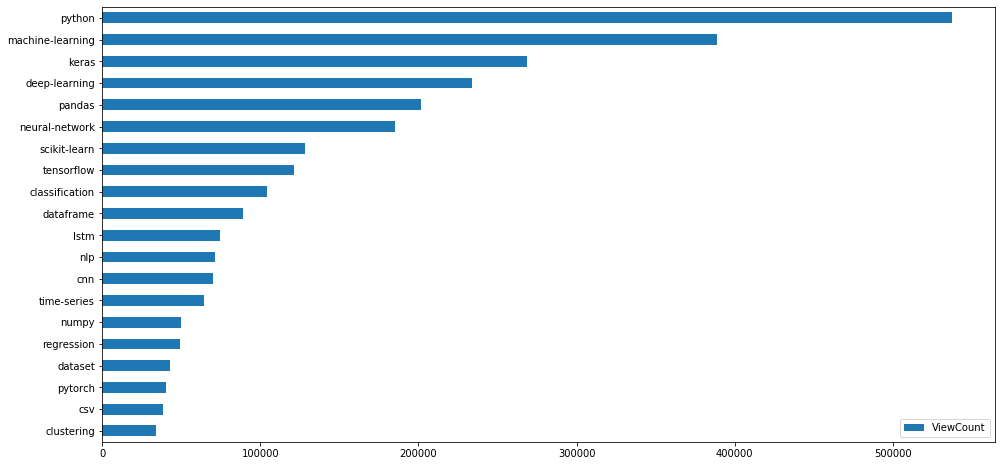

In [45]:
tag_view_count = dict()

for index, row in questions.iterrows():
    for tag in row['Tags']:
        if tag in tag_view_count:
            tag_view_count[tag] += row['ViewCount']
        else:
            tag_view_count[tag] = row['ViewCount']
            
tag_view_count = pd.DataFrame.from_dict(tag_view_count, orient="index")
tag_view_count.rename(columns={0: "ViewCount"}, inplace=True)

most_viewed = tag_view_count.sort_values(by="ViewCount").tail(20)

most_viewed.plot(kind="barh", figsize=(16,8))

Side by side

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001F41EC60BC8>],
      dtype=object)

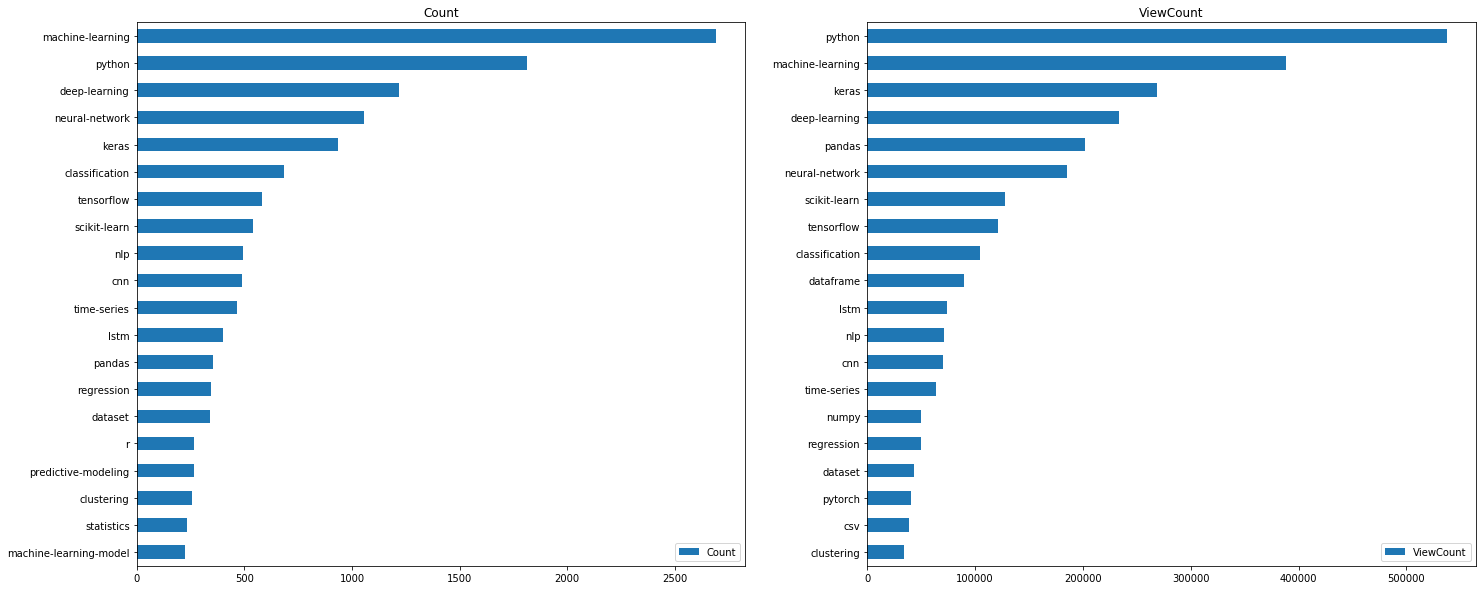

In [46]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches((24, 10))
most_used.plot(kind="barh", ax=axes[0], subplots=True)
most_viewed.plot(kind="barh", ax=axes[1], subplots=True)

In [47]:
in_used = pd.merge(most_used, most_viewed, how="left", left_index=True, right_index=True)
in_viewed = pd.merge(most_used, most_viewed, how="right", left_index=True, right_index=True)

## Relations Between Tags
One way of trying to gauge how pairs of tags are related to each other, is to count how many times each pair appears together. Let's do this.

We'll begin by creating a list of all tags.

In [48]:
all_tags = list(tag_count.index)

We'll now create a dataframe where each row will represent a tag, and each column as well. Something like this:

In [49]:
associations = pd.DataFrame(index=all_tags, columns=all_tags)
associations.iloc[0:4,0:4]

,machine-learning,data-mining,regression,linear-regression
machine-learning,NaN,NaN,NaN,NaN
data-mining,NaN,NaN,NaN,NaN
regression,NaN,NaN,NaN,NaN
linear-regression,NaN,NaN,NaN,NaN


We will now fill this dataframe with zeroes and then, for each lists of tags in questions["Tags"], we will increment the intervening tags by one. The end result will be a dataframe that for each pair of tags, it tells us how many times they were used together.

In [50]:
associations.fillna(0, inplace=True)

for tags in questions["Tags"]:
    associations.loc[tags, tags] += 1

This dataframe is quite large. Let's focus our attention on the most used tags. We'll add some colors to make it easier to talk about the dataframe. (At the time of this writing, GitHub's renderer does not display the colors, we suggest you use this solution notebook together with JupyterLab).



In [51]:
relations_most_used = associations.loc[most_used.index, most_used.index]

def style_cells(x):
    helper_df = pd.DataFrame('', index=x.index, columns=x.columns)
    helper_df.loc["time-series", "r"] = "background-color: yellow"
    helper_df.loc["r", "time-series"] = "background-color: yellow"
    for k in range(helper_df.shape[0]):
        helper_df.iloc[k,k] = "color: blue"
    
    return helper_df

relations_most_used.style.apply(style_cells, axis=None)

,machine-learning-model,statistics,clustering,predictive-modeling,r,dataset,regression,pandas,lstm,time-series,cnn,nlp,scikit-learn,tensorflow,classification,keras,neural-network,deep-learning,python,machine-learning
machine-learning-model,224,3,3,21,7,12,8,4,5,7,4,4,18,9,21,17,10,19,37,139
statistics,3,234,3,16,16,17,16,3,1,22,1,3,6,0,19,3,11,12,35,89
clustering,3,3,257,0,16,5,2,5,3,20,0,9,24,0,12,0,8,2,45,61
predictive-modeling,21,16,0,265,13,7,28,4,13,31,6,1,12,6,27,11,13,32,35,123
r,7,16,16,13,268,6,10,2,3,22,2,4,1,1,10,10,9,5,24,63
dataset,12,17,5,7,6,340,6,14,7,6,11,11,9,9,28,13,20,32,53,99
regression,8,16,2,28,10,6,347,6,11,24,6,2,37,9,34,31,42,21,59,119
pandas,4,3,5,4,2,14,6,354,7,19,1,3,37,3,3,3,1,1,244,62
lstm,5,1,3,13,3,7,11,7,402,87,24,19,2,43,20,133,69,103,61,71
time-series,7,22,20,31,22,6,24,19,87,466,8,0,12,9,25,51,33,44,105,131


The cells highlighted in yellow tell us that time-series was used together with r 22 times. The values in blue tell us how many times each of the tags was used. We saw earlier that machine-learning was used 2693 times and we confirm it in this dataframe.

It's hard for a human to understand what is going on in this dataframe. Let's create a heatmap. But before we do it, let's get rid of the values in blue, otherwise the colors will be too skewed.

In [52]:
for i in range(relations_most_used.shape[0]):
    relations_most_used.iloc[i,i] = pd.np.NaN

C:\Users\Ramin\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  


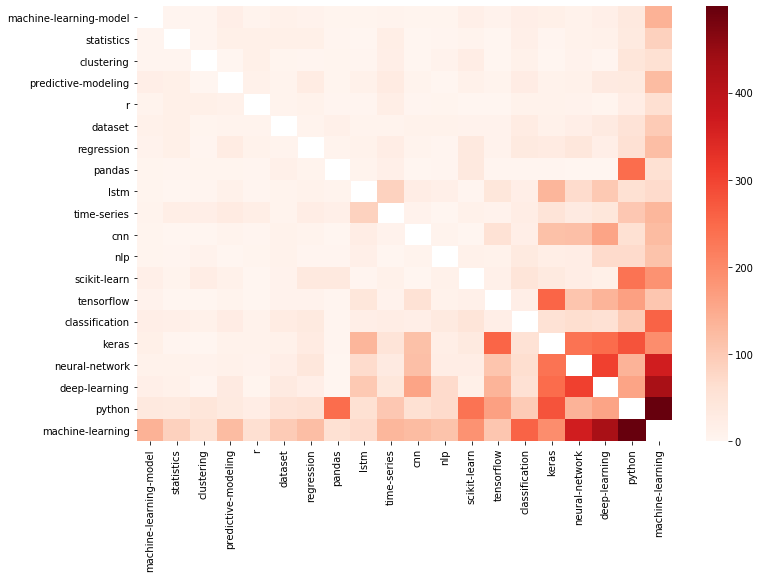

In [53]:
plt.figure(figsize=(12,8))
sns.heatmap(relations_most_used, cmap="Reds", annot=False)

The most used tags also seem to have the strongest relationships, as given by the dark concentration in the bottom right corner. However, this could simply be because each of these tags is used a lot, and so end up being used together a lot without possibly even having any strong relation between them.

A more intuitive manifestation of this phenomenon is the following. A lot of people buy bread, a lot of people buy toilet paper, so they end up being purchased together a lot, but purchasing one of them doesn't increase the chances of purchasing the other.

Another shortcoming of this attempt is that it only looks at relations between pairs of tags and not between multiple groups of tags. For example, it could be the case that when used together, dataset and scikit-learn have a "strong" relation to pandas, but each by itself doesn't.

So how do we attack both these problems? There is a powerful data mining technique that allows us to handle this: association rules. Association rules allow us to analytically spot relations like "people who purchase milk, also purchase eggs". Moreover, we can also measure how strong this relations are on several fronts: how common the relation is, how strong it is, and how independent the components of the relationship are.

We won't get into the details of it, as the technique is out of scope for this course, but it is a path worth investigating!

## Enter Domain Knowledge
Keras, scikit-learn, TensorFlow are all Python libraries that allow their users to employ deep learning (a type of neural network).

Most of the top tags are all intimately related with one central machine learning theme: deep learning. If we want to be very specific, we can suggest the creation of Python content that uses deep learning for classification problems (and other variations of this suggestion).

At the glance of an eye, someone with sufficient domain knowledge can tell that the most popular topic at the moment, as shown by our analysis, is deep learning.

## Just a Fad?
Let's read in the file into a dataframe called all_q. We'll parse the dates at read-time.

In [54]:
all_q = pd.read_csv("all_questions.csv", parse_dates=["CreationDate"])

We can use the same technique as before to clean the tags column.

In [55]:
all_q["Tags"] = all_q["Tags"].str.replace("^<|>$", "").str.split("><")

Before deciding which questions should be classified as being deep learning questions, we should decide what tags are deep learning tags.

The definition of what constitutes a deep learning tag we'll use is: a tag that belongs to the list ["lstm", "cnn", "scikit-learn", "tensorflow", "keras", "neural-network", "deep-learning"].

This list was obtained by looking at all the tags in most_used and seeing which ones had any relation to deep learning. You can use Google and read the tags descriptions to reach similar results.

We'll now create a function that assigns 1 to deep learning questions and 0 otherwise; and we use it.

In [56]:
def class_deep_learning(tags):
    for tag in tags:
        if tag in ["lstm", "cnn", "scikit-learn", "tensorflow",
                   "keras", "neural-network", "deep-learning"]:
            return 1
    return 0


In [57]:
all_q["DeepLearning"] = all_q["Tags"].apply(class_deep_learning)


In [58]:
all_q.sample(10)

,Id,CreationDate,Tags,DeepLearning
7711,18264,2017-04-11 10:25:57,"[neural-network, algorithms]",1
5929,57919,2019-08-21 04:33:48,[neural-network],1
1799,25220,2017-11-29 17:38:05,"[python, csv]",0
1263,45944,2019-02-21 10:38:13,"[jupyter, google, cloud]",0
5245,26742,2018-01-17 11:32:53,"[machine-learning, deep-learning, convolution]",1
9070,60317,2019-09-17 11:34:19,"[machine-learning, classification, scikit-learn]",1
3511,16268,2017-01-12 03:40:27,"[predictive-modeling, prediction]",0
6464,58171,2019-08-25 14:08:08,"[neural-network, deep-learning, autoencoder]",1
20516,14090,2016-09-19 12:21:42,"[classification, dataset, distribution]",0
5687,57861,2019-08-20 09:55:10,[nlp],0


The data-science-techonology landscape isn't something as dynamic to merit daily, weekly, or even monthly tracking. Let's track it quarterly.

Since we don't have all the data for the first quarter of 2020, we'll get rid of those dates:

In [59]:
all_q = all_q[all_q["CreationDate"].dt.year < 2020]

Let's create a column that identifies the quarter in which a question was asked.

In [60]:
def fetch_quarter(datetime):
    year = str(datetime.year)[-2:]
    quarter = str(((datetime.month-1) // 3) + 1)
    return "{y}Q{q}".format(y=year, q=quarter)

all_q["Quarter"] = all_q["CreationDate"].apply(fetch_quarter)
all_q.head()

,Id,CreationDate,Tags,DeepLearning,Quarter
0,45416,2019-02-12 00:36:29,"[python, keras, tensorflow, cnn, probability]",1,19Q1
1,45418,2019-02-12 00:50:39,[neural-network],1,19Q1
2,45422,2019-02-12 04:40:51,"[python, ibm-watson, chatbot]",0,19Q1
3,45426,2019-02-12 04:51:49,[keras],1,19Q1
4,45427,2019-02-12 05:08:24,"[r, predictive-modeling, machine-learning-mode...",0,19Q1


For the final stretch of this screen, we'll group by quarter and:

- Count the number of deep learning questions.
- Count the total number of questions.
- Compute the ratio between the two numbers above.

In [61]:
quarterly = all_q.groupby('Quarter').agg({"DeepLearning": ['sum', 'size']})
quarterly.columns = ['DeepLearningQuestions', 'TotalQuestions']
quarterly["DeepLearningRate"] = quarterly["DeepLearningQuestions"]\
                                /quarterly["TotalQuestions"]
# The following is done to help with visualizations later.
quarterly.reset_index(inplace=True)
quarterly.sample(5)

,Quarter,DeepLearningQuestions,TotalQuestions,DeepLearningRate
20,19Q2,935,2393,0.390723
12,17Q2,226,647,0.349304
9,16Q3,161,585,0.275214
14,17Q4,353,898,0.393096
1,14Q3,13,189,0.068783


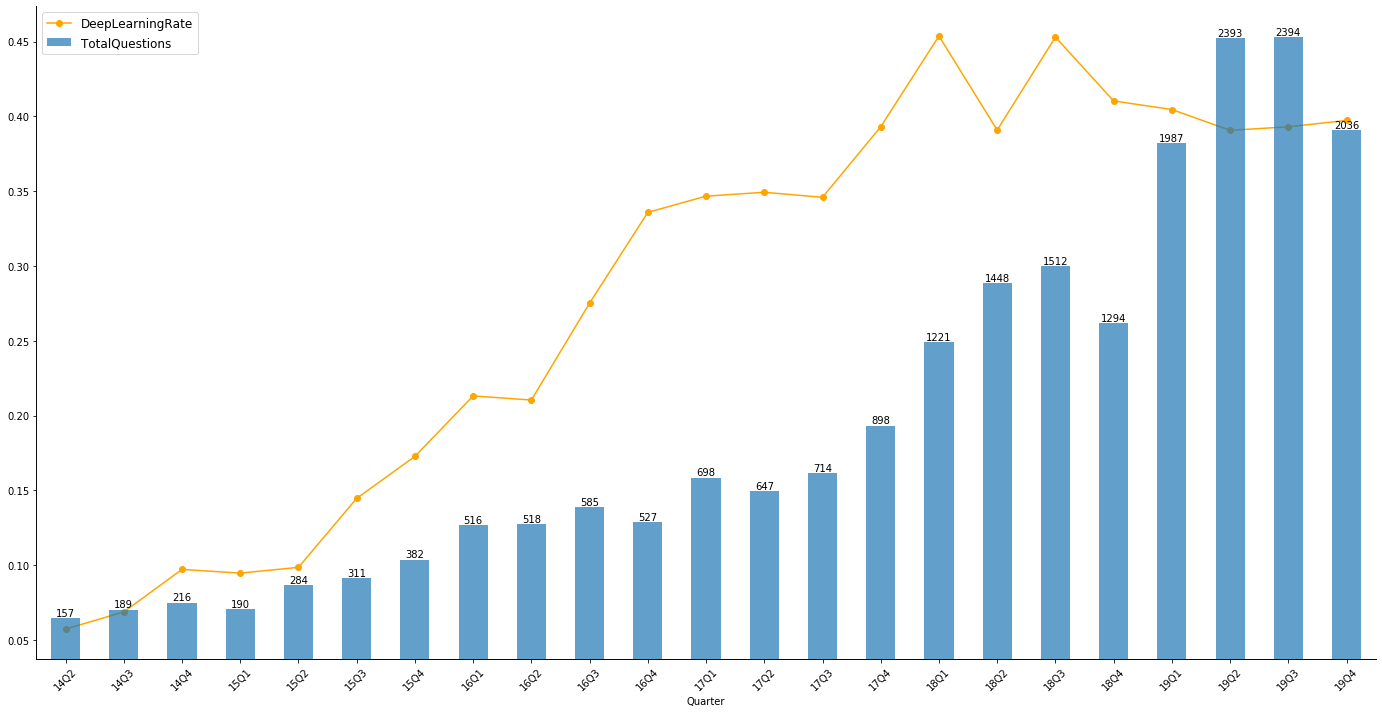

In [62]:
ax1 = quarterly.plot(x="Quarter", y="DeepLearningRate",
                    kind="line", linestyle="-", marker="o", color="orange",
                    figsize=(24,12)
                    )

ax2 = quarterly.plot(x="Quarter", y="TotalQuestions",
                     kind="bar", ax=ax1, secondary_y=True, alpha=0.7, rot=45)

for idx, t in quarterly["TotalQuestions"].iteritems():
    ax2.text(idx, t, str(t), ha="center", va="bottom")
xlims = ax1.get_xlim()

ax1.get_legend().remove()

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles=handles1 + handles2,
           labels=labels1 + labels2,
           loc="upper left", prop={"size": 12})


for ax in (ax1, ax2):
    for where in ("top", "right"):
        ax.spines[where].set_visible(False)
        ax.tick_params(right=False, labelright=False)


It seems that deep learning questions was a high-growth trend since the start of DSSE and it looks like it is plateauing. There is no evidence to suggest that interest in deep learning is decreasing and so we maintain our previous idea of proposing that we create deep learning content.